In [35]:
import socket, os
import numpy as np
from tensorflow.keras import layers as KL
from tqdm import tqdm
import glob, copy
import scipy
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K

# from freesurfer import deeplearn as fsd
import freesurfer as fs

import neurite as ne
import neurite_sandbox as nes
import voxelmorph as vxm
import voxelmorph_sandbox as vxms
from pathlib import Path
from tensorflow.keras.utils import to_categorical
import surfa as sf
import generators as gens

import layer_dict as ld
import pdb as gdb

import neurite as ne
import neurite_sandbox as nes
import voxelmorph as vxm
import voxelmorph_sandbox as vxms
from pathlib import Path
from tensorflow.keras.utils import to_categorical
import surfa as sf
from utils import *
import argparse



log_dir = "logs_subnets"
models_dir = "models_subnets"
num_epochs = 1000

    
weights_saver = PeriodicWeightsSaver(filepath=models_dir, save_freq=10)  # Save weights every 100 epochs

TB_callback = CustomTensorBoard(
    base_log_dir=log_dir,
    histogram_freq=100,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

initial_epoch=0
checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'

mse_wt = 1

vscale = 2
vscale = 1

dofit = True

# whether or not to train the synthseg net from scratch with the subnets
combined_training = True
combined_training = False

# whether or not to concat the (extracted) aseg features into the subnets
concat_aseg = False
concat_aseg = True

# have subnets only output the labels that ever occur in their location or all labels
use_lab2ind = True
use_lab2ind = False

# put losses on the individual subnets or not
use_subloss = False
use_subloss = True

# which optimizer to use
which_opt = 'sgd'
which_opt = 'adam'

# which subnet loss to use (if using a subnet loss)
subloss = 'mse'
subloss = 'dice'

# whether to use the insertion code on the subnet outputs (you always should, wasn't sure at first)
use_insertion = False
use_insertion = True

# whether to freeze the aseg weights when training the subnets
train_aseg = False
train_aseg = True

which_loss = 'both'
which_loss = 'mse'
which_loss = 'cce'
which_loss = 'dice'

same_contrast=False
same_contrast=True

# add synthetic outputs shapes to the images or not
oshapes = False
oshapes = True

# perform linear fitting on inputs to softmax to initialize things
fit_lin = True
fit_lin = False


# do affine augmentation or not
doaff = False
doaff = True


model_dir = 'models'
gpuid = -1
host = socket.gethostname()
from neurite_sandbox.tf.utils.utils import plot_fit_callback as pfc


print(f'host name {socket.gethostname()}')

# ngpus = 1 if os.getenv('NGPUS') is None else int(os.getenv('NGPUS'))

# ngpus =len(os.environ["CUDA_VISIBLE_DEVICES"])
# print(f'using {ngpus} gpus')
# if ngpus > 1:
#     model_device = '/gpu:0'
#     synth_device = '/gpu:1'
#     synth_gpu = 1
#     # dev_str = "0, 1"
#     dev_str = ", ".join(map(str, range(ngpus)))
#     print("dev_str:",dev_str)
# else:
#     model_device = '/gpu:0'
synth_device = '/gpu:0'
model_device = '/gpu:0'

synth_gpu = 0
dev_str = "0"


# if not dofit and host == 'serena.nmr.mgh.harvard.edu':
#     dev_str = '/cpu:0'
#     print(f'setting dev_str to {dev_str}')

os.environ["CUDA_VISIBLE_DEVICES"] = '/gpu:0'

# print(f'model_device {model_device}, synth_device {synth_device}, dev_str {dev_str}')

# print(f'physical GPU # is {os.getenv("SLURM_STEP_GPUS")}')
# ret = ne.utils.setup_device(dev_str)
# policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')

print(f'dofit {dofit}, doaff {doaff}, fit_lin {fit_lin}, oshapes {oshapes}, subnet loss {use_subloss}, use_lab2ind {use_lab2ind}, combined_training {combined_training}, insertion {use_insertion}, concat aseg {concat_aseg}, subloss {subloss}')


batch_size = 1

odir = '/autofs/vast/braindev/braindev/OASIS/OASIS1/synth-high-res/recon_subject'
subjects = [f for f in Path(odir).iterdir() if 'OASIS_OAS1_0' in str(f)]
seg_files = [f/f'mri/aparc+aseg.mgz' for f in tqdm(subjects)]
seg_files = [f/f'mri/aseg.mgz' for f in tqdm(subjects)]

if dofit:
    print(f'TRAINING model with loss {which_loss}')
else:
    print(f'loading model trained with {which_loss} loss')

target_shape = (192,)*3
inshape = target_shape


# number of subnets and the size of the input patch to each one
patch_size = 32
num_subnets = 16

# initial_epoch = args.initial_epoch

pad_size=4
# add some padding to the subnets so that there is always some context for each voxel
big_patch_size = patch_size + 2 * pad_size
phalf = patch_size // 2
bphalf = big_patch_size // 2

print(f'patch_size = {patch_size}, num_subnets = {num_subnets}, pad_size = {pad_size}')

ntest = 25
crop = -1 if dofit else ntest
crop = 25

lut = fs.lookups.default()

# csf = lut.search('CSF')[0]
lesion_label_orig = lut.search('Left-Lesion')
if len(lesion_label_orig) > 0:
    lesion_label_orig = lesion_label_orig[0]
else:   # not in the lut - add a new one
    lesion_label_orig = 77
    lut.add(lesion_label_orig, 'Lesion', color=[240,240,240])

if 'inited' not in locals() and 'inited' not in globals():
    inited = False

warp_max = 2
if not inited:
    # mri_segs_orig = [fs.Volume.read(str(fname)) for fname in tqdm(seg_files[:crop])]
    # mri_segs = [sf.load_volume(str(fname)) for fname in tqdm(seg_files[:crop])]
    mri_segs_orig = [sf.load_volume(str(fname)) for fname in tqdm(seg_files[:crop])]

    if vscale > 1:
        print(f'downsampling by {vscale}')
        mri_segs = [mri.reslice(vscale) for mri in tqdm(mri_segs_orig)]
    else:
        print(f'cropping to {target_shape}')
        mri_segs = [mri.fit_to_shape(target_shape, center='bbox') for mri in tqdm(mri_segs_orig)]
        # mri_segs = [mri.reshape(target_shape, center='bbox') for mri in tqdm(mri_segs)]

    np_segs_orig = [mri.data for mri in mri_segs]
    fname = 'npy/oasis_labels.npy'
    if os.path.exists(fname):
        print(f'loading unique labels in {len(mri_segs_orig)} from {fname}')
        labels_orig = np.load(fname)
    else:
        print(f'finding unique labels in {len(mri_segs_orig)} datasets...')
        labels_orig = np.unique(np.array(np_segs_orig))
        np.save(fname, labels_orig)

    # mapping = fs.lookups.tissue_type_recoder_no_skull(include_lesions=use_lesions)
    mapping = fs.lookups.nonlateral_aseg_recoder()
    target_lut = mapping.target_lut
    lut_name = 'nonlat.txt'
    mri_segs_recoded = [fs.label.recode(mri, mapping) for mri in mri_segs]  
    lesion_label = target_lut.search('Left-Lesion')[0]
    np_segs = [vol.data for vol in mri_segs_recoded]
    labels_in = np.unique(np.array(np_segs)).astype(int)
    if lesion_label not in labels_in:
        l = list(labels_in)
        l.append(lesion_label)
        labels_in = np.array(l)
    nlabels_small = len(labels_in)
    label_map = {}
    keys = mapping.mapping.keys()
    lab_to_ind = np.zeros((labels_orig.max()+1,), dtype=int)
    for label in labels_orig:
        if label not in keys:
            output_label = 0
        else:
            output_label = mapping.mapping[label]
        label_map[label] = output_label
        lab_to_ind[label] = output_label


    import generators as gens
    vxm_model = gens.read_vxm_model(inshape)
    vxm_smooth_wt = np.zeros((1, 1))
    vxm_smooth_wt[0,0] = .3   # warp regularization hyper parameter
    
    gen_model = gens.create_gen_model(np_segs, oshapes, synth_device, nlabels_small, labels_in, inshape, warp_max)

    mapping = fs.lookups.nonlateral_aseg_recoder()
    target_lut = mapping.target_lut
    lut_name = 'nonlat.txt'
    adir_2d = '/autofs/cluster/vxmdata1/FS_Slim/proc/cleaned/Buckner39'
    adir = '/autofs/cluster/freesurfer/subjects/atlases/aseg_atlas'
    mname = 'seg_edited.mgz'
    vname = 'norm.mgz'
    sfile = os.path.join(adir, 'scripts', 'subjects.txt')
    with open(sfile, 'r') as f:
        subjects = f.read().split('\n')[0:-1]


    mri_man_segs = []  # manual segs
    mri_norms = []  # mri vols
    mri_norms_orig = []
    mri_man_segs_orig = []
    print("subjects",subjects)
    subjects = subjects[0:10]
    for s in tqdm(subjects):
        # mri_seg_orig = fs.Volume.read(os.path.join(adir, s, 'mri', mname))
        mri_seg_orig = sf.load_volume(os.path.join(adir, s, 'mri', mname))

    
        mri_man_segs_orig.append(mri_seg_orig)
        # mri_seg = mri_seg_orig.fit_to_shape(target_shape, center='bbox')
        mri_seg = mri_seg_orig.reshape(target_shape)
        mri_man_segs.append(mri_seg)
        # mri_norm_orig = fs.Volume.read(os.path.join(adir, s, 'mri', vname))
        mri_norm_orig = sf.load_volume(os.path.join(adir, s, 'mri', vname))

        mri_norm = mri_norm_orig.resample_like(mri_seg)
        mri_norms.append(mri_norm)
        mri_norms_orig.append(mri_norm_orig)
        

    mri_man_segs_recoded = [fs.label.recode(mri, mapping) for mri in tqdm(mri_man_segs)]

    # mri_seg_atlas = fs.Volume.read("aseg_atlas.mgz")
    mri_seg_atlas = sf.load_volume("aseg_atlas.mgz").reshape(target_shape)
    hard_seg = np.argmax(mri_seg_atlas.data, axis=-1)
    mri_hard_seg = mri_seg_atlas.copy()
    mri_hard_seg.data = hard_seg
    mri_hard_seg_cropped = mri_hard_seg.reshape(target_shape)
    print(mri_hard_seg_cropped.shape)
    mri_norm_atlas = sf.load_volume("norm_atlas.mgz").resample_like(mri_hard_seg)
    print(mri_norm_atlas.shape)
    # mri_hard_seg = mri_seg_atlas.copy(hard_seg).fit_to_shape(target_shape, center='bbox')
    # mri_norm_atlas = fs.Volume.read("norm_atlas.mgz").resample_like(mri_hard_seg)

    mri_seg_atlas = mri_seg_atlas.resample_like(mri_hard_seg)
    norm_atlas = (mri_norm_atlas.data / mri_norm_atlas.data.max())[np.newaxis, ..., np.newaxis]
    # norm atlas shape:  (1, 192, 192, 192, 1) (192, 192, 192) (192, 192, 192, 17)
    print("norm atlas shape: ", norm_atlas.shape,mri_hard_seg.shape,mri_seg_atlas.shape)
    
    f = 256
    conf = {
        'def.enc_nf': [f] * 4,
        'def.dec_nf': [f] * 4,
        'def.add_nf': [f] * 4,
        'def.hyp_den': [32] * 4,
    }
    vxm_model = vxm.networks.HyperVxmJoint(in_shape=inshape, **conf)
    vxm_model.load_weights(os.path.join('models_from_Malte', f'hyp_mse_uni_{f}_lm10_mid.h5'))
    # vxm_model = vxms.networks.VxmJointAverage(in_shape=inshape, **conf)
    # vxm_model.load_weights(os.path.join('models_from_Malte', f'VxmJointAverage{f}.h5'))
    #aseg_model = tf.keras.models.load_model('aseg.h5', custom_objects=ld.layer_dict)
    aseg_train_fscale = 1.1
    if 1:
        aseg_train_fname = f'aseg_subnet/aseg.fscale.{aseg_train_fscale}.h5'
        print(f'loading aseg model {aseg_train_fname}')
        aseg_model = tf.keras.models.load_model(aseg_train_fname, 
                                                custom_objects=ld.layer_dict)
    else:
        aseg_model = tf.keras.models.load_model('aseg.h5', custom_objects=ld.layer_dict)

    l = np.zeros((1, 1))
    l[0,0] = .3   # warp regularization hyper parameter

    # psize = (norm_atlas.shape[1] - mri_norms[0].shape[0]) // 2
    # pad = ((0,0), (psize,psize), (psize, psize), (psize, psize), (0, 0))
    # lfunc = ne.losses.Dice(nb_labels=nlabels_small, weights=None, check_input_limits=False).mean_loss
    lfunc = nes.losses.DiceNonzero(nlabels_small, weights=None, check_input_limits=False).loss
    read_cached = False
    read_cached = True
    new_cache = True  # fscale specific
    if not read_cached:
        dice_list = []
        elist = []
        elist_in_atlas = []
        alist_in_atlas = []
        nlist_in_atlas = []
        mlist_in_atlas = []
        for sno, s in enumerate(tqdm(subjects)):
            mseg_onehot = np.eye(nlabels_small)[mri_man_segs_recoded[sno].data]
            norm = (mri_norms[sno].data / mri_norms[sno].data.max())[np.newaxis, ..., np.newaxis]
            pred = aseg_model.predict(norm)
            transform = vxm_model.predict([l, norm, norm_atlas])
            # transform = transform[:, psize:-psize, psize:-psize, psize:-psize, :]
            dice = lfunc(tf.convert_to_tensor(mseg_onehot[np.newaxis], tf.float32), 
                         tf.convert_to_tensor(pred, tf.float32))
            dice_list.append(dice.numpy())
            ev = (mseg_onehot - pred[0])
            evol = (ev**2).sum(axis=-1)
            elist.append(evol)
            evol_in_atlas = vxm.layers.SpatialTransformer(interp_method='linear', fill_value=0)([evol[np.newaxis, ..., np.newaxis], transform])
            norm_in_atlas = vxm.layers.SpatialTransformer(interp_method='linear', fill_value=0)([norm, transform])
            aseg_in_atlas = vxm.layers.SpatialTransformer(interp_method='linear', fill_value=0)([pred[0][np.newaxis, ...], transform])
            mseg_in_atlas = vxm.layers.SpatialTransformer(interp_method='linear', fill_value=0)([mseg_onehot[np.newaxis, ...], transform])
            elist_in_atlas.append(evol_in_atlas.numpy().squeeze())
            nlist_in_atlas.append(norm_in_atlas.numpy().squeeze())
            #alist_in_atlas.append(np.argmax(aseg_in_atlas.numpy(), axis=-1).squeeze())
            #mlist_in_atlas.append(np.argmax(mseg_in_atlas.numpy(), axis=-1).squeeze())
            alist_in_atlas.append(aseg_in_atlas.numpy().squeeze())
            mlist_in_atlas.append(mseg_in_atlas.numpy().squeeze())

        np.save(f'npy_malte/elist_in_atlas.fscale.{aseg_train_fscale}.npy', elist_in_atlas)
        np.save(f'npy_malte/nlist_in_atlas.fscale.{aseg_train_fscale}.npy', nlist_in_atlas)
        np.save(f'npy_malte/alist_in_atlas.fscale.{aseg_train_fscale}.npy', alist_in_atlas)
        np.save(f'npy_malte/mlist_in_atlas.fscale.{aseg_train_fscale}.npy', mlist_in_atlas)

        print('computing index occurence volumes')
        aseg_inds = np.argmax(np.array(alist_in_atlas), axis=-1)
        mseg_inds = np.argmax(np.array(mlist_in_atlas), axis=-1)
        max_inds = nlabels_small
        mseg_ind_vol = np.zeros(target_shape + (max_inds,))
        aseg_ind_vol = np.zeros(target_shape + (max_inds,))
        mseg_num_inds = np.zeros(target_shape)
        aseg_num_inds = np.zeros(target_shape)
        for x in tqdm(range(aseg_inds.shape[1])):
            for y in range(aseg_inds.shape[2]):
                for z in range(aseg_inds.shape[3]):
                    ind_list = -1 * np.ones((max_inds,))
                    u = np.unique(mseg_inds[:, x, y, z])
                    for lno, l in enumerate(u):
                        if lno >= max_inds:
                            break
                            mseg_ind_vol[x, y, z, lno] = l
                
                    mseg_num_inds[x, y, z] = len(u)
                    ind_list = -1 * np.ones((max_inds,))
                    u = np.unique(aseg_inds[:, x, y, z])
                    for lno, l in enumerate(u):
                        aseg_ind_vol[x, y, z, lno] = l

                    aseg_num_inds[x, y, z] = len(u)

        inds_trivial = np.nonzero(mseg_num_inds < 2)
        evol_avg = np.array(elist_in_atlas).mean(axis=0)
        evol_avg[inds_trivial] = 0
        nvol_avg = np.array(nlist_in_atlas).mean(axis=0)
        low_val = 0 if num_subnets == 20 else -1000
        nbhd_img_orig = scipy.ndimage.convolve(evol_avg, np.ones((patch_size,)*3)/(patch_size**3), 
                                               mode='constant',  cval=low_val)
        np.save(f'npy_malte/nbhd_img.fscale.{aseg_train_fscale}.npy', nbhd_img_orig)
        np.save(f'npy_malte/evol_avg.fscale.{aseg_train_fscale}.npy', evol_avg)
        np.save(f'npy_malte/nvol_avg.fscale.{aseg_train_fscale}.npy', nvol_avg)
    else:   # not dofit
        if new_cache:
            print(f'reading cached volumes scale {aseg_train_fscale}')
            nbhd_img_orig = np.load('npy/nbhd_img.npy', allow_pickle=True)
            elist_in_atlas = np.load(f'npy_malte/elist_in_atlas.fscale.{aseg_train_fscale}.npy', allow_pickle=True)
            nlist_in_atlas = np.load(f'npy_malte/nlist_in_atlas.fscale.{aseg_train_fscale}.npy', allow_pickle=True) 
            alist_in_atlas = np.load(f'npy_malte/alist_in_atlas.fscale.{aseg_train_fscale}.npy', allow_pickle=True)
            mlist_in_atlas = np.load(f'npy_malte/mlist_in_atlas.fscale.{aseg_train_fscale}.npy', allow_pickle=True)
            evol_avg = np.load(f'npy_malte/evol_avg.fscale.{aseg_train_fscale}.npy', allow_pickle=True)
            nvol_avg = np.load(f'npy_malte/nvol_avg.fscale.{aseg_train_fscale}.npy', allow_pickle=True)
        else:
            print('reading cached volumes')
            nbhd_img_orig = np.load('npy_malte/nbhd_img.npy', allow_pickle=True)
            elist_in_atlas = np.load('npy_malte/elist_in_atlas.npy', allow_pickle=True)
            nlist_in_atlas = np.load('npy_malte/nlist_in_atlas.npy', allow_pickle=True)
            alist_in_atlas = np.load('npy_malte/alist_in_atlas.npy', allow_pickle=True)
            mlist_in_atlas = np.load('npy_malte/mlist_in_atlas.npy', allow_pickle=True)
            evol_avg = np.load('npy_malte/evol_avg.npy', allow_pickle=True)
            nvol_avg = np.load('npy_malte/nvol_avg.npy', allow_pickle=True)

    inited = True


nbhd_img = nbhd_img_orig.copy()
mseg_avg = np.argmax(np.array(mlist_in_atlas).mean(axis=0), axis=-1)
aseg_avg = np.argmax(np.array(alist_in_atlas).mean(axis=0), axis=-1)
    
mlist_ind = np.argmax(np.array(mlist_in_atlas), axis=-1)
alist_ind = np.argmax(np.array(alist_in_atlas), axis=-1)


if dofit:    #  run training
    patch_labels = []
    patch_centers = []
    for netno in range(num_subnets):
        max_ind = np.argmax(nbhd_img[bphalf:-bphalf, bphalf:-bphalf, bphalf:-bphalf])
        patch_center = np.unravel_index(max_ind, nbhd_img[bphalf:-bphalf, bphalf:-bphalf, bphalf:-bphalf].shape) + np.array([bphalf, bphalf, bphalf])
        # should use bphalf here
        x0 = patch_center[0]-patch_size//2
        x1 = x0 + patch_size 
        y0 = patch_center[1]-patch_size//2
        y1 = y0 + patch_size 
        z0 = patch_center[2]-patch_size//2
        z1 = z0 + patch_size
        labels_mseg = np.unique(mlist_ind[:, x0:x1, y0:y1, z0:z1])
        labels_aseg = np.unique(alist_ind[:, x0:x1, y0:y1, z0:z1])
        print(f'patch at {patch_center}: labels {labels_mseg}')
        patch_centers.append(patch_center)
        bx0 = patch_center[0]-big_patch_size//2
        bx1 = x0 + big_patch_size 
        by0 = patch_center[1]-big_patch_size//2
        by1 = y0 + big_patch_size 
        bz0 = patch_center[2]-big_patch_size//2
        bz1 = z0 + big_patch_size
        nbhd_img[bx0:bx1, by0:by1, bz0:bz1] = -1000  # prevent overlap of subsequent patches
        print("patch label shape:",labels_mseg.shape)
        patch_labels.append(labels_mseg)

    print('saving patch centers and labels...')
    np.savez(f'npy_malte/patch_labels.{patch_size}.{num_subnets}.{pad_size}.npy', *patch_labels)
    np.save(f'npy_malte/patch_centers.{patch_size}.{num_subnets}.{pad_size}.npy', patch_centers)
else:
    
    print('loading patch centers and labels...')
    patch_labels_files = np.load(f'npy_malte/patch_labels.{patch_size}.{num_subnets}.{pad_size}.npz', allow_pickle=True)
    patch_labels = [patch_labels_files[key] for key in patch_labels_files.files]
    patch_centers = np.load(f'npy_malte/patch_centers.{patch_size}.{num_subnets}.{pad_size}.npy', allow_pickle=True)



aseg_train_fname = f'aseg_subnet/aseg.fscale.{aseg_train_fscale}.h5'
print(f'loading aseg model {aseg_train_fname}')
aseg_model = tf.keras.models.load_model(aseg_train_fname, custom_objects=ld.layer_dict)

# find last feature layer of the aseg unet
for lno in range(len(aseg_model.layers)-1, 0, -1):
    aseg_layer = aseg_model.layers[lno]
    if aseg_layer.name.startswith("unet_conv_uparm"):
        break

nfeats = aseg_layer.output[0].get_shape().as_list()[-1]


gen_model = gens.create_gen_model(np_segs, oshapes, synth_device, nlabels_small, labels_in, inshape)


nb_levels = int(np.log2(patch_size))-1
nb_levels = int(np.log2(big_patch_size))-1
nb_conv_per_level = 2
unet_scale = 1
    
unet_nf = []
fscale = 1.1
fscale = 1


for level in range(nb_levels):
    filters_in_this_level = []
    for layer in range(nb_conv_per_level):
        filters_in_this_level.append(int(fscale**level*nfeats))
        
    unet_nf.append(filters_in_this_level)


tf.compat.v1.enable_eager_execution()

lr = 1e-5
lr = 1e-4
name = f'subnets.outside.unet_nf.{nfeats}.warp_max.{warp_max}.oshapes.{oshapes}.num_subnets.{num_subnets}.psize.{patch_size}.pad.{pad_size}.lab2ind.{use_lab2ind}.lr.{lr}.subloss.{use_subloss}.insertion.{use_insertion}.combined_training.{combined_training}.train_aseg.{train_aseg}'
if not concat_aseg:
    name += f'.concat_aseg.{concat_aseg}'
if use_subloss and subloss != 'dice':
    name += f'.subloss.{subloss}'
if which_opt != 'adam':
    name += f'.which_opt.{which_opt}'



label_weights = np.ones((1,nlabels_small,))
# label_weights[0,-1] = .01  # downweight lesion class
lfunc = ne.losses.Dice(nb_labels=nlabels_small, weights=None, check_input_limits=False).mean_loss
lfunc = nes.losses.DiceNonzero(nlabels_small, weights=None, check_input_limits=False).loss
if use_subloss:
    if subloss == 'dice':
        thresh = -.2*3
    else:
        thresh = 8
else:
        thresh = -.2*2
    

cooldown = 25
patience = 600


losses = [lfunc]
loss_weights = [1]
if use_subloss:
    if subloss == 'mse':
        lfunc_subnet = lambda a, b: mse_wt * tf.keras.losses.MSE(a, b)
    else:
        lfunc_subnet = lfunc
    losses += [lfunc_subnet]
    loss_weights += [1]


unet_device = model_device if (fit_lin or dofit) else synth_device
with tf.device(unet_device):     # add the subnets to the big unet
    aseg_shape = aseg_layer.output.get_shape().as_list()[1:]
    aseg_linear_out = aseg_model.layers[-3].output  # tensor right before outputs compressed to nlabels
    subnet_outputs_to_add = [aseg_linear_out]  # add subnet outputs to this tensor for final output
    subnet_outputs = []  # list of subnet outputs each nlabels_small long (only for using subloss)
    subnet_patches = []  # spatial location of the subnet patches
    pre_lab2ind = []

    for subnet_no in range(num_subnets):
        bx0 = patch_centers[subnet_no][0]-big_patch_size//2
        bx1 = bx0 + big_patch_size 
        by0 = patch_centers[subnet_no][1]-big_patch_size//2
        by1 = by0 + big_patch_size 
        bz0 = patch_centers[subnet_no][2]-big_patch_size//2
        bz1 = bz0 + big_patch_size 
        # only inner part without padding
        x0 = patch_centers[subnet_no][0]-patch_size//2
        x1 = x0 + patch_size 
        y0 = patch_centers[subnet_no][1]-patch_size//2
        y1 = y0 + patch_size 
        z0 = patch_centers[subnet_no][2]-patch_size//2
        z1 = z0 + patch_size 
        # labels_mseg = np.unique(mlist_ind[:, bx0:bx1, by0:by1, bz0:bz1])
        labels_mseg = np.unique(mlist_ind[:, x0:x1, y0:y1, z0:z1])
        noutputs = len(labels_mseg) if use_lab2ind else nlabels_small

        # extract a patch of (1) the data on the uparm of the big net and (2) the input volume
        aseg_patch = nes.layers.ExtractPatch(((bx0, bx1), (by0, by1), (bz0, bz1)), 
                                             name=f'aseg_patch{subnet_no}')(aseg_layer.output)
        patch_input = nes.layers.ExtractPatch(((bx0, bx1), (by0, by1), (bz0, bz1)),
                                              name=f'subnet_input{subnet_no}')(aseg_model.inputs[0])
        nf = aseg_patch.get_shape().as_list()[-1]
        print("unet, big_patch_size, noutputs: ",unet_nf,big_patch_size,noutputs)
        subnet_lin = ne.models.unet(unet_nf, (big_patch_size,)*3+(1,), None, 3, noutputs, feat_mult=None, final_pred_activation='linear', name=f'subnet{subnet_no}')

        if use_lab2ind:
            # concat aseg_model info to second-to-last layer of subnet
            if concat_aseg:
                tmp_model = tf.keras.Model(subnet_lin.inputs, subnet_lin.layers[-3].output)
                tmp_out = tmp_model(patch_input)
                unet_concat = KL.Concatenate(name=f'subnet_in{subnet_no}', axis=-1)([tmp_out, aseg_patch])
                Conv = getattr(KL, 'Conv%dD' % 3)
                subnet_out = Conv(noutputs, 3, strides=1, padding='same')(unet_concat)
            else:
                subnet_out = subnet_lin(patch_input)
            
            pre_lab2ind.append(subnet_out)
            unet_out = nes.layers.IndexToLabel(labels_mseg, nlabels_small, name=f'IndToLab{subnet_no}')(subnet_out)
        else:  # what about concatting in the non lab2ind case????
            unet_out = subnet_lin(patch_input)

        # crop out the beginning and ending pad regions so output is just central patch_size
        p0 = pad_size
        p1 = pad_size+patch_size
        patch_output = nes.layers.ExtractPatch(((p0, p1), (p0, p1), (p0, p1)),
                                               name=f'subnet_output{subnet_no}')(unet_out)

        if use_subloss:
            if subloss == 'dice':
                subnet_softmax = KL.Softmax(name=f'subnet{subnet_no}_softmax')(patch_output)
                subnet_outputs.append(subnet_softmax[:, tf.newaxis, ...])
            else:   # just include the linear output for mse loss
                subnet_outputs.append(patch_output[:, tf.newaxis, ...])

            subnet_patches.append(((x0, x1), (y0, y1), (z0, z1)))

        if subnet_no == 0 or not use_insertion:
            # padding = ((x0, aseg_shape[0]-x1), (y0, aseg_shape[1]-y1), (z0, aseg_shape[2]-z1))
            # padded_unet_output = nes.layers.Pad(padding=padding, mode='constant', name=f'pad_subnet{subnet_no}')(patch_output)
            from keras.layers import ZeroPadding3D

            # Assuming 'patch_output' is a Keras tensor
            padding = ((x0, aseg_shape[0] - x1), (y0, aseg_shape[1] - y1), (z0, aseg_shape[2] - z1))
            padded_unet_output = ZeroPadding3D(padding=padding, name=f'pad_subnet{subnet_no}')(patch_output)

            if not use_insertion:
                subnet_outputs_to_add.append(padded_unet_output)
            else:   # initialize one big tensor with patch outputs
                big_patches_output = padded_unet_output
        else:  # just insert this patch (since they don't overlap don't need to add)
            offset = ((x0, y0, z0, 0))
            big_patches_output = nes.layers.InsertPatch(big_patches_output, offset, 
                                                         name=f'patch_insert{subnet_no}')([
                                                             patch_output, big_patches_output])
            

    if not use_insertion:
        summed_aseg_outputs = KL.Add(name='patch_plus_unet')(subnet_outputs_to_add)
    else:
        summed_patch_outputs = KL.Lambda(lambda x: x, name='summed_patch_outputs')(big_patches_output)
        summed_aseg_outputs = KL.Add(name='patch_plus_unet')([summed_patch_outputs, aseg_linear_out])

    #Conv = getattr(KL, 'Conv%dD' % 3)
    #linear_out = Conv(nlabels_small, 3, strides=1, padding='same')(summed_aseg_outputs)

    model_lin = tf.keras.Model(aseg_model.inputs, [summed_aseg_outputs])
    softmax_out = KL.Softmax(name='seg')(summed_aseg_outputs)
    outputs = [softmax_out]
    if use_subloss:
        subnet_out = KL.Concatenate(name='subloss', axis=1)(subnet_outputs)
        outputs += [subnet_out]
    model = tf.keras.Model(aseg_model.inputs, outputs)

# vxm_model: registeration model
# create the training (synth) and validation (on real data) generators
with tf.device(synth_device):
    val_size = 20 
    gen = gens.synth_gen(mri_segs_recoded, gen_model, vxm_model, norm_atlas, 
                         None, labels_in, 
                         batch_size=batch_size, 
                         subnet_patches=subnet_patches if use_subloss else None,
                         use_log_for_subnet=subloss == 'mse',
                         use_rand=True, gpuid=synth_gpu, debug=False, add_outside=oshapes)
    vgen = gens.real_gen(mri_man_segs_recoded, mri_norms, vxm_model, norm_atlas, 
                         None, labels_in, 
                         batch_size=batch_size, use_rand=True,
                         use_log_for_subnet=subloss == 'mse',
                         subnet_patches=subnet_patches if use_subloss else None,
                         gpuid=synth_gpu, debug=False, add_outside=oshapes)



# set this to nonzero if restarting training from an interrupted run
initial_epoch = 1
initial_epoch = 0

if not use_subloss:
    key_replacements = {
        'loss' : 'seg_loss',
        'val_loss' : 'val_seg_loss'
    }
else:
    key_replacements = None





host name rtx-08.nmr.mgh.harvard.edu
dofit True, doaff True, fit_lin False, oshapes True, subnet loss True, use_lab2ind False, combined_training False, insertion True, concat aseg True, subloss dice


100%|██████████| 415/415 [00:00<00:00, 160946.48it/s]

TRAINING model with loss dice
patch_size = 32, num_subnets = 16, pad_size = 4


patch at [ 96 140  49]: labels [0 1 2 3 4 5]
patch label shape: (6,)
patch at [ 61 128  35]: labels [ 0  1  2  4  5 13]
patch label shape: (6,)
patch at [125 132  34]: labels [ 0  1  2  4  5 13]
patch label shape: (6,)
patch at [ 78 129  82]: labels [ 0  1  2  3  4  5 10 11 15 16]
patch label shape: (10,)
patch at [ 94 113  20]: labels [ 0  1  2  3 16]
patch label shape: (5,)
patch at [102 119  55]: labels [ 0  1  2  3  4  5  6 11 13 16]
patch label shape: (10,)
patch at [119 130 119]: labels [ 0  1  2  3  6  8  9 10 11 12 13 14 15 16]
patch label shape: (14,)
patch at [ 75 126 112]: labels [ 0  1  2  3  4  5  8  9 10 11 12 13 14 15 16]
patch label shape: (15,)
patch at [ 97 157  73]: labels [ 0  3  4  5 10]
patch label shape: (5,)
patch at [147 122  66]: labels [ 0  1  2  3  4  5 13]
patch label shape: (7,)
patch at [117 113  84]: labels [ 0  1  2  3  4  5  6  8  9 10 11 13 15 16]
patch label shape: (14,)
patch at [94 50 51]: labels [ 0  1  2 13]
patch label shape: (4,)
patch at [ 95 

In [28]:
# a = sf.load_volume("/autofs/space/bal_004/users/jd1677/datasets/OASIS/atlas_022.mgz")
import surfa as sf
import numpy as np
import tensorflow as tf

# a=sf.load_volume("aseg_atlas.mgz")
# b=sf.load_volume("norm_atlas.mgz")

# c=sf.load_volume("atlas_022_onehot.mgz")
# d=sf.load_volume("atlas_022.mgz")
num_classes = len(np.unique(c))
one_hot_data = tf.one_hot(c.data, num_classes)

print(a.shape,b.shape)
print(c.shape,d.shape,one_hot_data.shape)
# mri_norm_atlas


    
atlas=c
label_map = {}



print(len(np.unique(c)))
print(len(np.unique(atlas)))

print(np.unique(atlas))

(256, 256, 256, 17) (256, 256, 256)
(192, 192, 192) (192, 192, 192) (192, 192, 192, 33)
1 Cerebral-Exterior
2 Cerebral-White-Matter
3 Cerebral-Cortex
4 Lateral-Ventricle
5 Inf-Lat-Vent
6 Cerebellum-Exterior
7 Cerebellum-White-Matter
8 Cerebellum-Cortex
9 Thalamus-unused
10 Thalamus
11 Caudate
12 Putamen
13 Pallidum
14 3rd-Ventricle
15 4th-Ventricle
16 Brain-Stem
17 Hippocampus
18 Amygdala
19 Insula
20 Operculum
21 Line-1
22 Line-2
23 Line-3
24 CSF
25 Lesion
26 Accumbens-area
27 Substancia-Nigra
28 VentralDC
29 undetermined
30 vessel
31 choroid-plexus
32 F3orb
33 aOg
34 WMCrowns
35 mOg
36 pOg
37 Stellate
38 Porg
39 Aorg
19
19
[ 0.  2.  3.  4.  5.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 18. 24. 26.
 28.]


In [27]:
label_map

{1: 'Cerebral-Exterior',
 2: 'Cerebral-White-Matter',
 3: 'Cerebral-Cortex',
 4: 'Lateral-Ventricle',
 5: 'Inf-Lat-Vent',
 6: 'Cerebellum-Exterior',
 7: 'Cerebellum-White-Matter',
 8: 'Cerebellum-Cortex',
 9: 'Thalamus-unused',
 10: 'Thalamus',
 11: 'Caudate',
 12: 'Putamen',
 13: 'Pallidum',
 14: '3rd-Ventricle',
 15: '4th-Ventricle',
 16: 'Brain-Stem',
 17: 'Hippocampus',
 18: 'Amygdala',
 19: 'Insula',
 20: 'Operculum',
 21: 'Line-1',
 22: 'Line-2',
 23: 'Line-3',
 24: 'CSF',
 25: 'Lesion',
 26: 'Accumbens-area',
 27: 'Substancia-Nigra',
 28: 'VentralDC',
 29: 'undetermined',
 30: 'vessel',
 31: 'choroid-plexus',
 32: 'F3orb',
 33: 'aOg',
 34: 'WMCrowns',
 35: 'mOg',
 36: 'pOg',
 37: 'Stellate',
 38: 'Porg',
 39: 'Aorg',
 40: 'Cerebral-Exterior',
 41: 'Cerebral-White-Matter',
 42: 'Cerebral-Cortex',
 43: 'Lateral-Ventricle',
 44: 'Inf-Lat-Vent',
 45: 'Cerebellum-Exterior',
 46: 'Cerebellum-White-Matter',
 47: 'Cerebellum-Cortex',
 48: 'Thalamus-unused',
 49: 'Thalamus',
 50: 'Caudat

In [29]:
reverse_label_map

{'Cerebral-Exterior': 40,
 'Cerebral-White-Matter': 41,
 'Cerebral-Cortex': 42,
 'Lateral-Ventricle': 43,
 'Inf-Lat-Vent': 44,
 'Cerebellum-Exterior': 45,
 'Cerebellum-White-Matter': 46,
 'Cerebellum-Cortex': 47,
 'Thalamus-unused': 48,
 'Thalamus': 49,
 'Caudate': 50,
 'Putamen': 51,
 'Pallidum': 52,
 '3rd-Ventricle': 14,
 '4th-Ventricle': 15,
 'Brain-Stem': 16,
 'Hippocampus': 53,
 'Amygdala': 54,
 'Insula': 55,
 'Operculum': 56,
 'Line-1': 21,
 'Line-2': 22,
 'Line-3': 23,
 'CSF': 24,
 'Lesion': 57,
 'Accumbens-area': 58,
 'Substancia-Nigra': 59,
 'VentralDC': 60,
 'undetermined': 29,
 'vessel': 30,
 'choroid-plexus': 31,
 'F3orb': 32,
 'aOg': 33,
 'WMCrowns': 34,
 'mOg': 35,
 'pOg': 36,
 'Stellate': 37,
 'Porg': 38,
 'Aorg': 39}

In [36]:
checkpoint_path = 'models_subnets/weights_epoch_300.h5'
with tf.device(model_device):
    if os.path.exists(checkpoint_path):
        print("checkpoint_path",checkpoint_path)
        model.load_weights(checkpoint_path)
    else:
        print("Checkpoint file not found.")

checkpoint_path models_subnets/weights_epoch_300.h5


In [15]:
import nibabel as nib
import numpy as np
ilist = []
tseg = []
plist = []
dlist = []
choroid_label = target_lut.search('Left-Choroid')[0]

num_gen = 5
cached_image =True
predict_now = False
if cached_image:
    ilist = [sf.load_volume(f"output/image{i}.nii.gz") for i in range(num_gen)]
    tseg = [sf.load_volume(f"output/tseg{i}.nii.gz") for i in range(num_gen)]
    plist = [sf.load_volume(f"output/pseg{i}.nii.gz") for i in range(num_gen)]
    if predict_now:
        for i in range(num_gen):
            inb = ilist[i]
            outb = tseg[i]
            inb = np.expand_dims(inb, axis=(0,-1))
            pred = model.predict(inb)
            plist.append(np.argmax(pred[0].squeeze(), axis=-1).copy())
        pseg = np.array(plist)
        for i in range(num_gen):
            nib.save(nib.Nifti1Image(pseg[i].astype(np.int32), np.eye(4), header=None), f"output/pseg{i}.nii.gz")
    imgs = np.array(ilist)
    tseg = np.array(tseg)
    pseg = np.array(plist)

else:
    for i in range(num_gen):
        inb, outb = next(vgen)
        ilist.append(inb[0].squeeze().copy())
        tseg.append(np.argmax(outb[0].squeeze(), axis=-1).copy())

        inb = np.expand_dims(ilist[0], axis=(0,-1))
        pred = model.predict(inb)
        plist.append(np.argmax(pred[0].squeeze(), axis=-1).copy())
    
    imgs = np.array(ilist)
    tseg = np.array(tseg)
    pseg = np.array(plist)
    
    for i in range(num_gen):
        nib.save(nib.Nifti1Image(imgs[i].astype(np.float32), np.eye(4), header=None), f"output/image{i}.nii.gz")
        nib.save(nib.Nifti1Image(tseg[i].astype(np.int32), np.eye(4), header=None), f"output/tseg{i}.nii.gz")
        nib.save(nib.Nifti1Image(pseg[i].astype(np.int32), np.eye(4), header=None), f"output/pseg{i}.nii.gz")

In [16]:
# model.summary()


0.7477863997943364


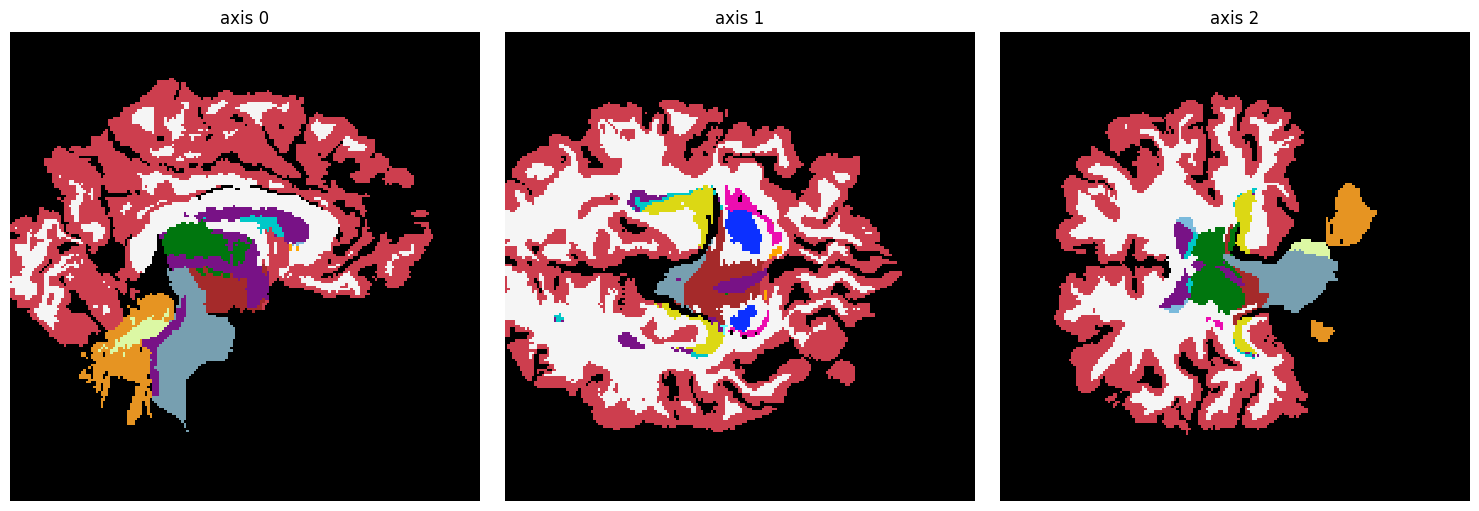

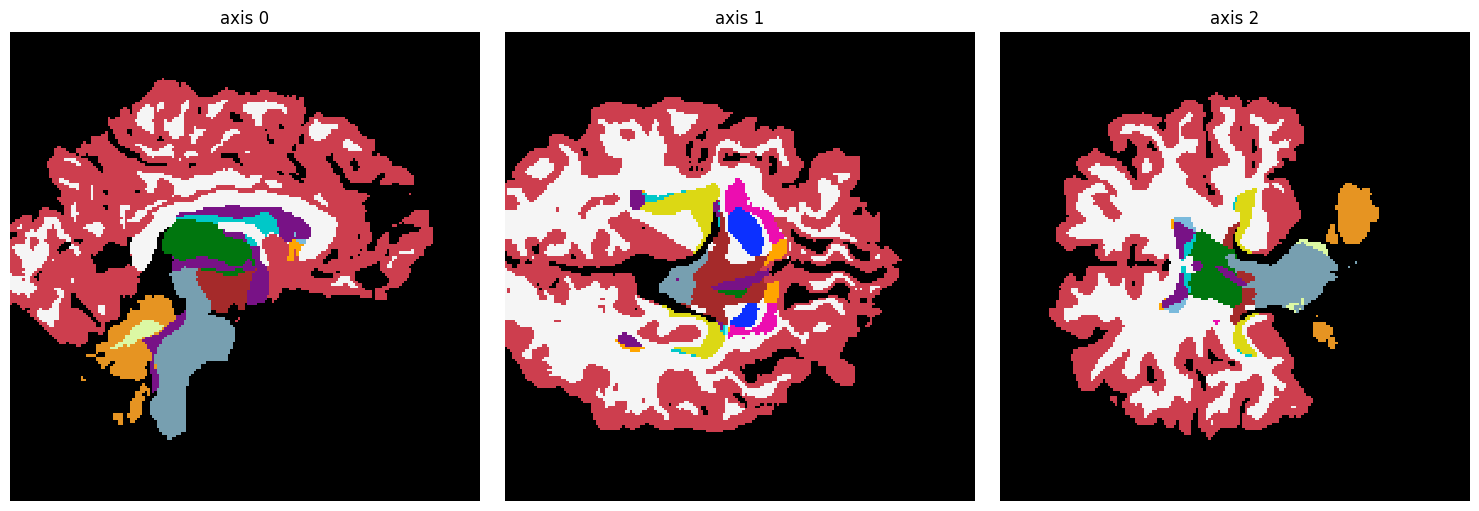

0.677912034919762


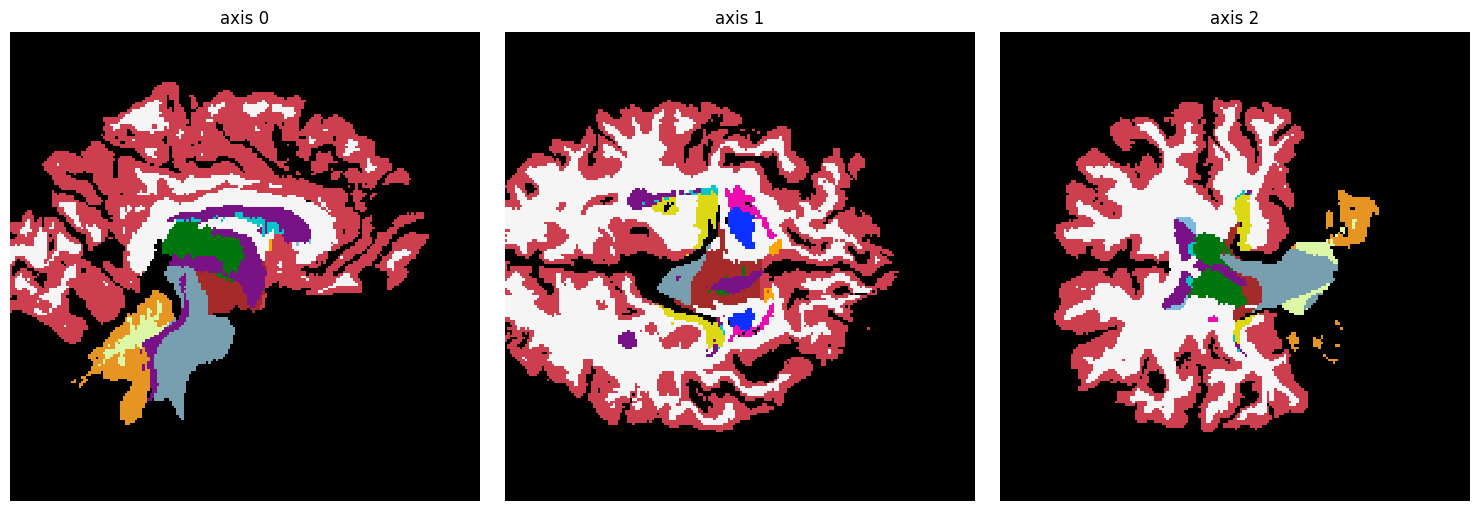

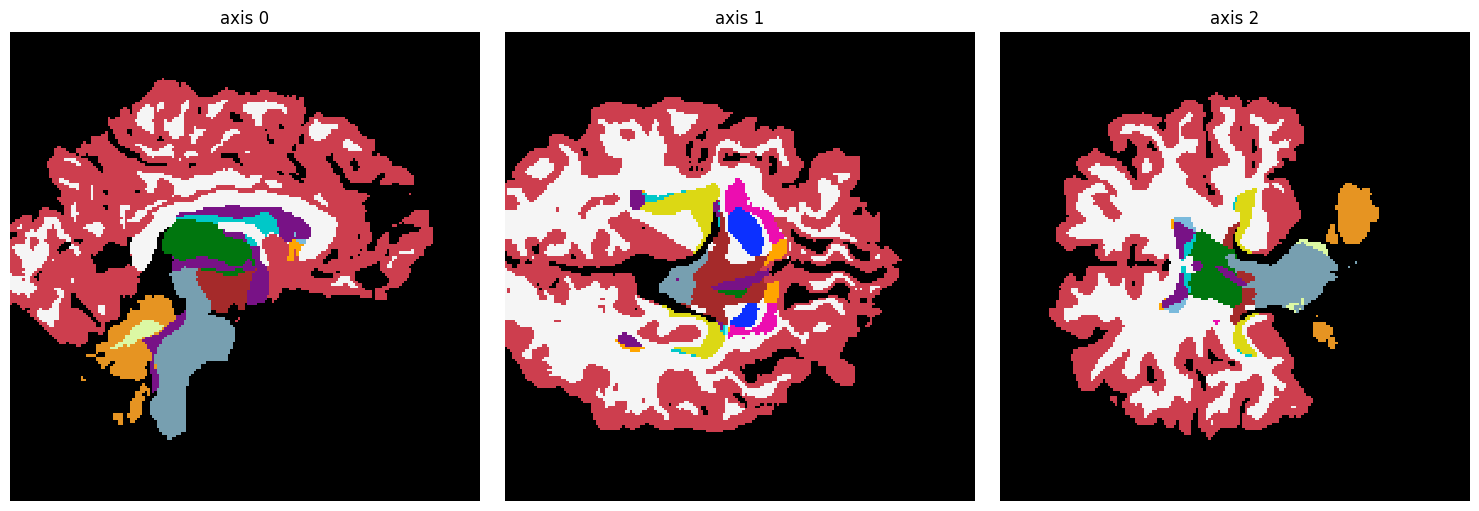

0.6888484488143014


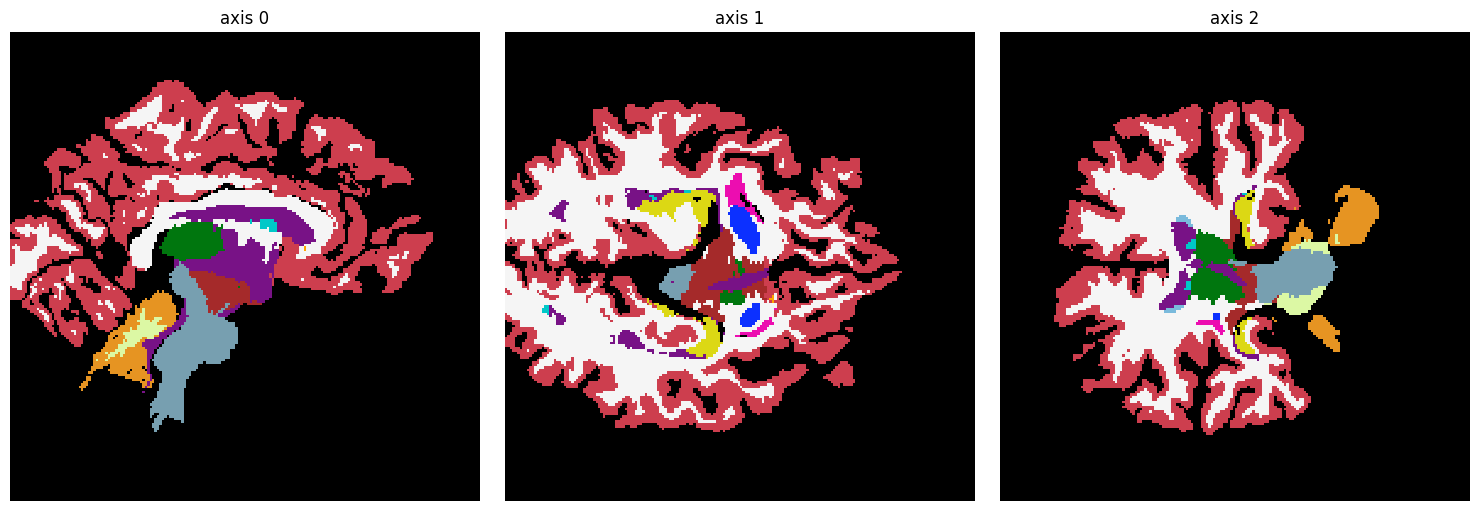

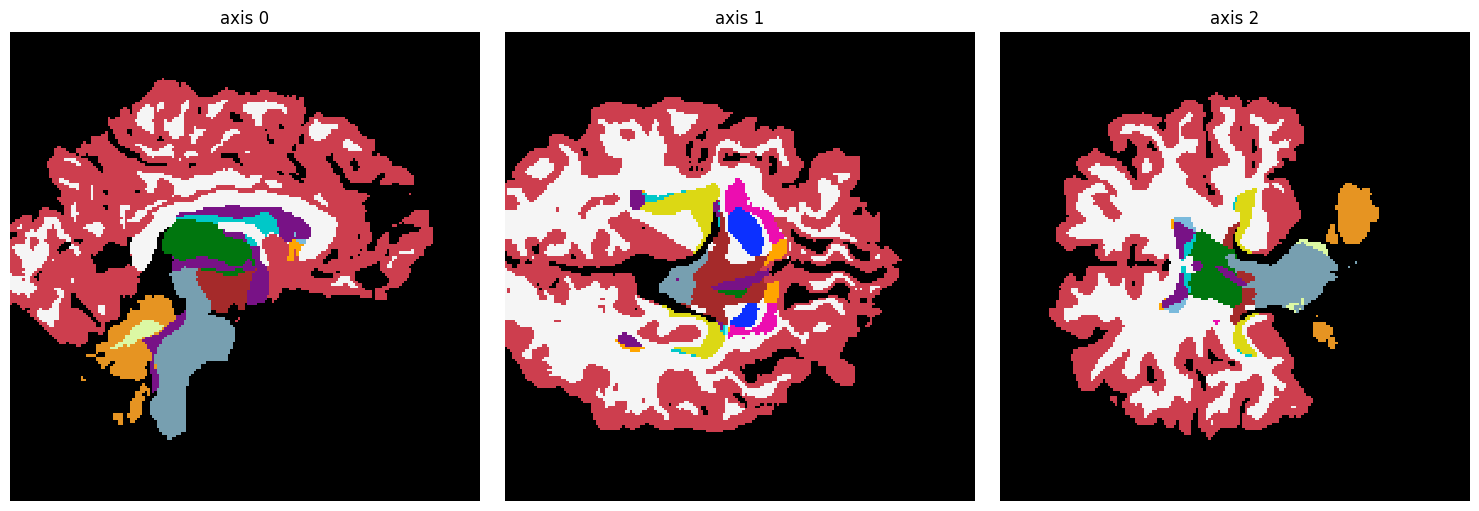

0.7566379731321765


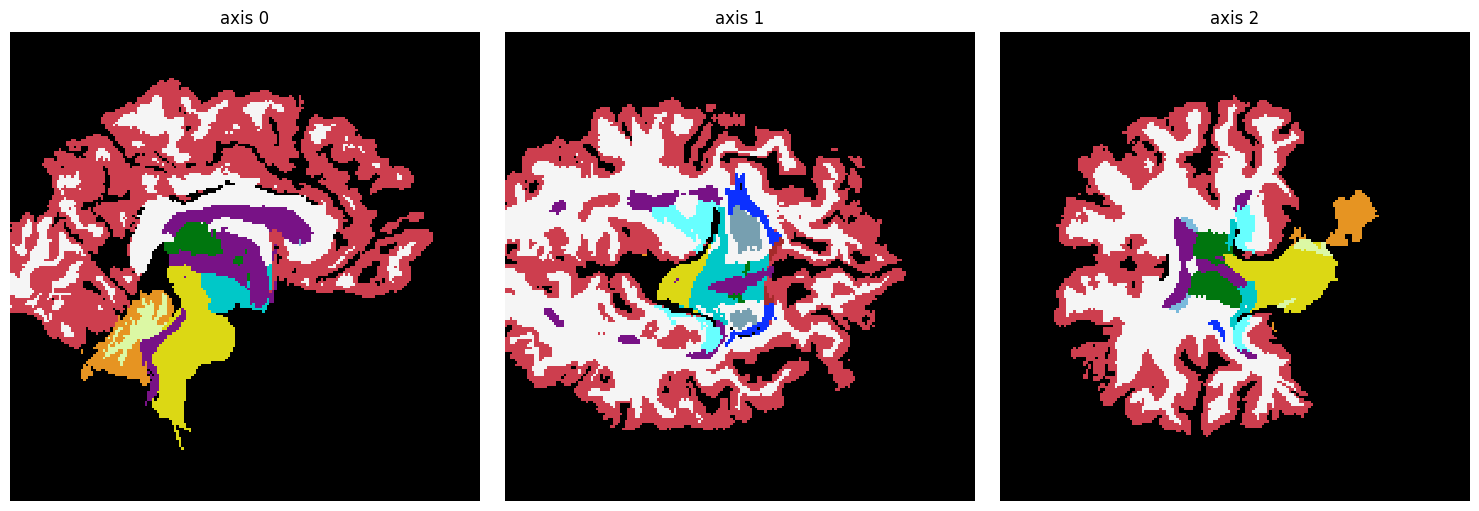

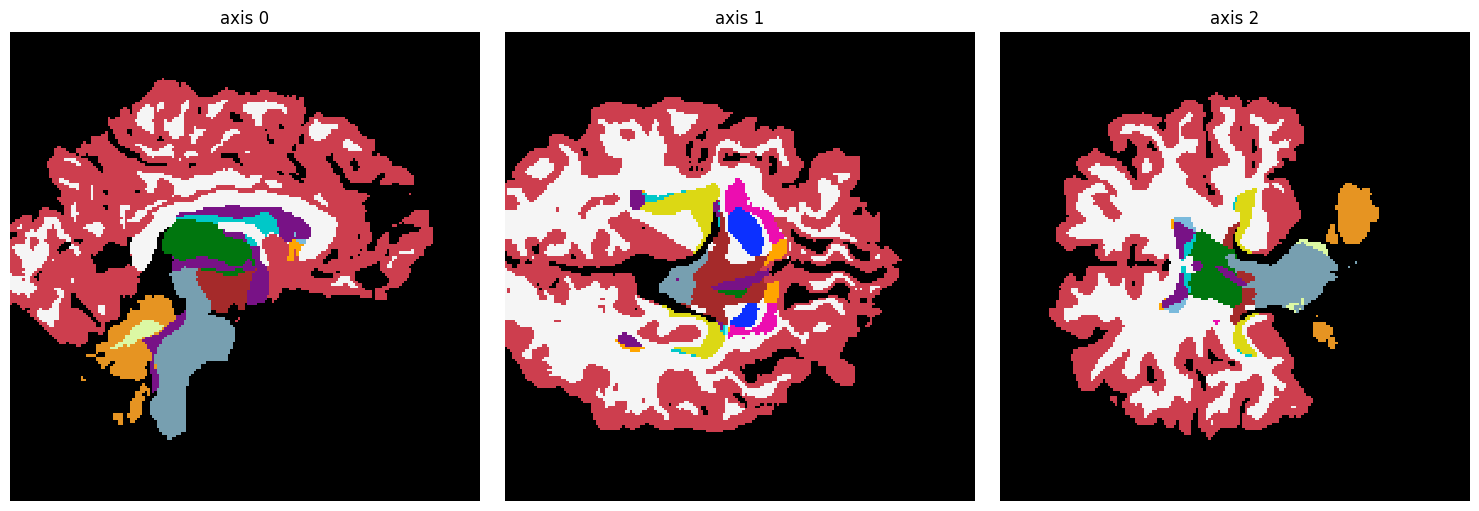

0.6888484488143014


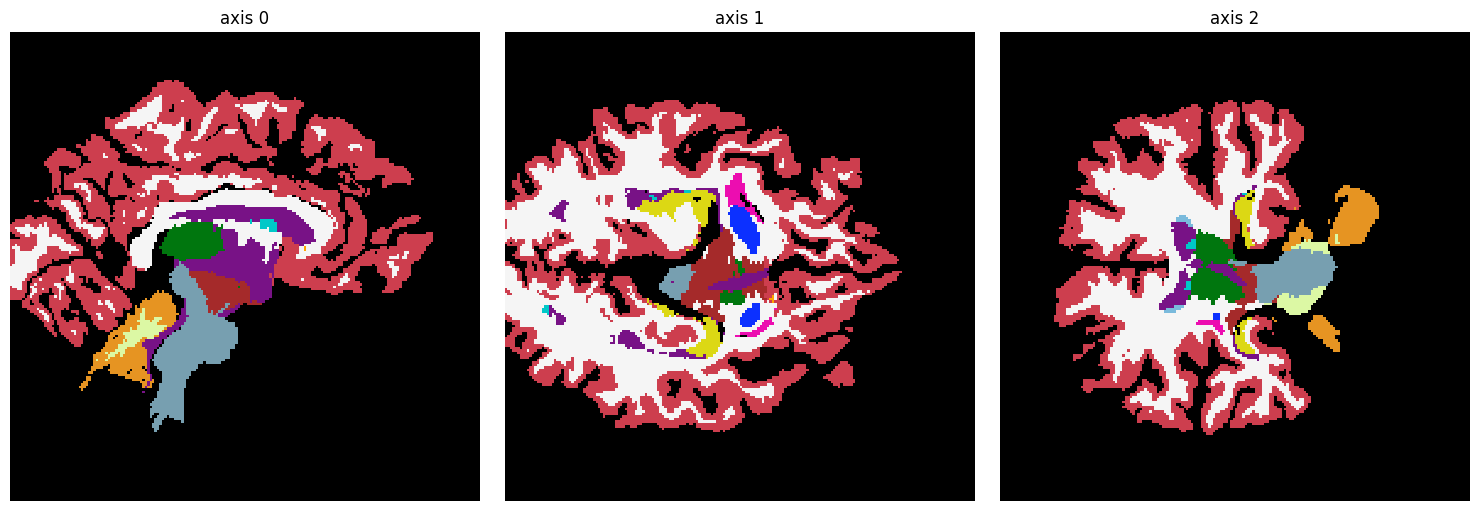

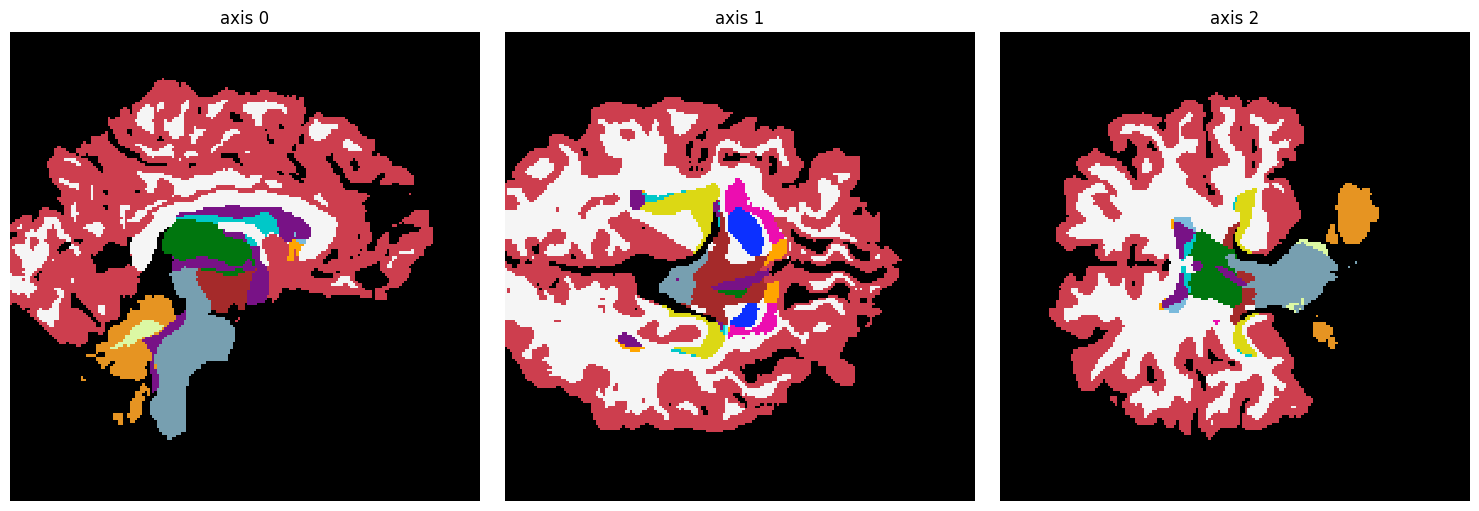

average dice: 0.7120066610949756


In [20]:
# def dice_coefficient(y_true, y_pred):
#     intersection = np.sum(y_true * y_pred)
#     union = np.sum(y_true) + np.sum(y_pred)
#     return (2.0 * intersection) / (union) 

first_slice_numbers = [100,102,77]
fs_cmap, fs_norm = make_cmap('nonlat.txt') 
dice_scores = []
for i in range(num_gen):
    t = tseg[i].astype(np.int32)
    p = pseg[i].astype(np.int32)
    dice_score = my_nonzero_hard_dice(t,p)
    dice_scores.append(dice_score)
    print(dice_score)
    ne.plot.volume3D(t, cmaps=[fs_cmap],slice_nos=first_slice_numbers)
    ne.plot.volume3D(p, cmaps=[fs_cmap],slice_nos=first_slice_numbers)
print("average dice:",np.mean(dice_scores))

In [43]:
first_slice_numbers

[100, 102, 77]